## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Chennai, Tamil Nadu is home to a large number of business, from micro to  big companies..It is also a great tourist destination. In this project we will determine the optimal location to open a restaurant in the Chennai district, and will be targeted at stakeholders interested in opening a restaurant in Chennai. Since we are not aware of what type of restaurant is popular in Chennai, we will also determine the most popular type(s) of restaurants in Chennai. We will utilize data science and machine learning techniques in order to do this. This project will be of interest to anyone wanting to open a restaurant in Chennai, and as a secondary application can also be useful to anyone wanting to visit or live in Chennai.

## Data <a name="data"></a>

In this project we will utilize three datasets in order to solve our problem. The first dataset is a list of municipalities. This data set was scraped from Wikipedia using BeautifulSoup. The next data set is one contain the latitude and longitude for each municipality. This dataset was obtaining using Geocoder package. The file containing the list of venues was obtained using the Foursquare API. We selected all venues not just restaurants in order to see where restaurants were more popular. These are the top 5 rows of these data sets.

In [1]:
#import all libraries needed
from bs4 import BeautifulSoup as bs #library for web scraping
import requests

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
#for determining optimal k
from sklearn import metrics
from scipy.spatial.distance import cdist

#!conda install -c conda-forge geocoder --yes
import geocoder

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Obtaining the data 

first lets scrape a table from wikipedia 

In [2]:
request_url='https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai'
request_url

'https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai'

In [3]:
r=requests.get(request_url)

In [4]:
soup=bs(r.content)

In [5]:
neighbourhoods=[]
ul_tag=soup.find_all('ul')[1:9]
for li_tag in ul_tag:
    a_tag=li_tag.find_all('a')
    for a_tag in a_tag:
        text=a_tag.text
        neighbourhoods.append(text)
    
neighbourhoods[:5]

['Red Hills', 'Royapuram', 'Korukkupet', 'Vyasarpadi', 'Tondiarpet']

In [6]:
chennai_df=pd.DataFrame()
chennai_df['Neighbourhood']=neighbourhoods
chennai_df.head()

,Neighbourhood
0,Red Hills
1,Royapuram
2,Korukkupet
3,Vyasarpadi
4,Tondiarpet


Next we import the Longitude and Latitude data  for each Municipality

In [7]:
lat_lng_coords = None
latitude=[]
longitude=[]
for neighbourhoods in chennai_df['Neighbourhood']:
    while(lat_lng_coords is None):
      g = geocoder.arcgis('{}, Tamil Nadu, India'.format(neighbourhoods))
      lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    lat_lng_coords=None

Merge the two dataframes

In [8]:
chennai_df['Latitude']=latitude
chennai_df['Longitude']=longitude
chennai_df.head()

,Neighbourhood,Latitude,Longitude
0,Red Hills,13.19543,80.18431
1,Royapuram,13.11394,80.29420
2,Korukkupet,13.11680,80.27726
3,Vyasarpadi,13.11778,80.25168
4,Tondiarpet,13.12923,80.28955


In [9]:
print(chennai_df.shape)
chennai_df.drop_duplicates(inplace=True)
print(chennai_df.shape)

(173, 3)
(167, 3)


Next we are going to use the Foursquare API to obtain venue data 

In [10]:
CLIENT_ID = 'MZIJC3XZIK5NQATIOFACON2FMCDOEF2WXDMZSI24RWAKSYPT' # your Foursquare ID
CLIENT_SECRET = 'ZGCS44WZIZJEREVEALG5BV0ODXP14DP33ZM0AKE0J3VL0PJ3' # your Foursquare Secret
VERSION = '20200731'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MZIJC3XZIK5NQATIOFACON2FMCDOEF2WXDMZSI24RWAKSYPT
CLIENT_SECRET:ZGCS44WZIZJEREVEALG5BV0ODXP14DP33ZM0AKE0J3VL0PJ3


Let's create a function to get the venues  

In [11]:
LIMIT=100#top 100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipalities', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [13]:
chennai_venues = getNearbyVenues(chennai_df['Neighbourhood'],
                                   latitudes=chennai_df['Latitude'],
                                   longitudes=chennai_df['Longitude']
                                  )

Red Hills
Royapuram
Korukkupet
Vyasarpadi
Tondiarpet
Tiruvottiyur
Ennore
Minjur
Old Washermenpet
Madhavaram
Manali New Town
Naravarikuppam
Sowcarpet
Puzhal
Moolakadai
Central
Kodungaiyur
Madhavaram Milk Colony
Mathur MMDA
Kolathur
Parry's Corner
Purasawalkam
Perambur
Manali
Vallalar Nagar
New Washermenpet
Mannadi
George Town
Basin Bridge
Park Town
Periamet
Choolai
Vepery
Pattalam
Pulinanthope
M.K.B. Nagar
Selavoyal
Manjambakkam
Ponniammanmedu
Sembiam
T.V.K. Nagar
ICF Colony
Lakshmipuram
Oragadam
Ayapakkam
Pattravakkam
Thirumullaivoyal north
Avadi
Kathivakkam
Kathirvedu
Erukanchery
Broadway
Jamalia
Kallikuppam
Pattabiram
Kosapet
Villivakkam
Porur
manapakkam
Anna Nagar
Aminjikarai
Ambattur
Defence Colony
Padi
Ayappakkam
Korattur
Mogappair
Arumbakkam
Pudur
Maduravoyal
Koyambedu
Ashok Nagar
K.K. Nagar
Karambakkam
Vadapalani
Saligramam
Virugambakkam
Alwarthirunagar
Valasaravakkam
Thirunindravur
Thirumangalam
Thirumullaivayal
Thiruverkadu
Nandambakkam
Nerkundrum
Nesapakkam
Nolambur
Ramapuram

In [16]:
print(chennai_venues.shape)
chennai_venues=chennai_venues.drop(chennai_venues[(chennai_venues['Venue Category']=='ATM') | (chennai_venues['Venue Category']=='Train Station')\
                                    | (chennai_venues['Venue Category']=='Platform') | (chennai_venues['Venue Category']=='Bus Station')].index)
chennai_venues.head()


(1640, 7)


,Municipalities,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Red Hills,13.19543,80.18431,Hotel Balaji Bavan,13.193716,80.185292,Indian Restaurant
1,Red Hills,13.19543,80.18431,Pvr Cinemas Skls Galaxy Mall,13.191586,80.186100,Movie Theater
2,Red Hills,13.19543,80.18431,Skls Galaxy Mall,13.191500,80.186038,Shopping Mall
3,Red Hills,13.19543,80.18431,Lakshmi Theatre,13.189894,80.188758,Multiplex
4,Red Hills,13.19543,80.18431,Universal Gym,13.190710,80.177946,Gym


Check the Venues Returned for each Municipality 

In [15]:
chennai_venues.groupby('Municipalities').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Municipalities,,,,,,
Adyar,68,68,68,68,68,68
Alandur,16,16,16,16,16,16
Alwarthirunagar,13,13,13,13,13,13
Ambattur,4,4,4,4,4,4
Aminjikarai,18,18,18,18,18,18
Anna Nagar,68,68,68,68,68,68
Annanur,2,2,2,2,2,2
Arumbakkam,14,14,14,14,14,14
Ashok Nagar,25,25,25,25,25,25


## Methodology <a name="methodology"></a>

We begin our analysis by utilizing one hot encoding on the data, in order to make it easier to work with catgorical variables, use 1 to represent a venue catagory being present, and 0 to represent it not being present.

In [17]:
# one hot encoding
c_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")

# add municipalities column back to dataframe
c_onehot['Municipalities'] = chennai_venues['Municipalities'] 

# move municipalities column to the first column
fixed_columns = [c_onehot.columns[-1]] + list(c_onehot.columns[:-1])
c_onehot = c_onehot[fixed_columns]

print(c_onehot.shape)
c_onehot.head(50)

(1640, 180)


,Municipalities,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Stop,Business Service,Café,Campground,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cricket Ground,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Leather Goods Store,Light Rail Station,Lighthouse,Lounge,Market,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Pool,Pool Hall,Portuguese Restaurant,Pub,Rajasthani Restaurant,Recreation Center,Resort,Restaurant,Rock Club,Russian Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Surf Spot,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store
0,Red Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Red Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Red Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Red Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next we will group rows by muncipality and mean of frequency of occurance of each catageory 

In [18]:
c_grouped = c_onehot.groupby('Municipalities').mean().reset_index()
c_grouped

,Municipalities,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bed & Breakfast,Bengali Restaurant,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Stop,Business Service,Café,Campground,Cantonese Restaurant,Chinese Restaurant,Chocolate Shop,Church,City,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cricket Ground,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Leather Goods Store,Light Rail Station,Lighthouse,Lounge,Market,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Pool,Pool Hall,Portuguese Restaurant,Pub,Rajasthani Restaurant,Recreation Center,Resort,Restaurant,Rock Club,Russian Restaurant,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Supermarket,Surf Spot,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Warehouse Store,Whisky Bar,Women's Store
0,Adyar,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.014706,0.0,0.000000,0.044118,0.0,0.000000,0.014706,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.014706,0.00,0.0000,0.000000,0.014706,0.014706,0.014706,0.000000,0.000000,0.014706,0.0,0.000000,0.000000,0.014706,0.014706,0.014706,0.000000,0.029412,0.000000,0.0,0.000000,0.044118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.014706,0.014706,0.00,0.000000,0.000000,0.000000,0.014706,0.014706,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.029412,0.250000,0.000000,0.000000,0.000000,0.014706,0.00,0.00,0.000000,0.044118,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044118,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.014706,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000

In [19]:
c_grouped.shape

(147, 180)

Print with each Municipality along with its top 5 venues 

In [20]:
 num_top_venues = 5

for municipality in c_grouped['Municipalities']:
    print("----"+municipality+"----")
    temp = c_grouped[c_grouped['Municipalities'] == municipality].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adyar----
                  venue  freq
0     Indian Restaurant  0.25
1                  Café  0.06
2      Asian Restaurant  0.04
3  Fast Food Restaurant  0.04
4           Pizza Place  0.04


----Alandur----
               venue  freq
0  Indian Restaurant  0.19
1             Bakery  0.12
2      Metro Station  0.12
3          Hotel Bar  0.06
4               Café  0.06


----Alwarthirunagar----
                  venue  freq
0        Clothing Store  0.23
1  Fast Food Restaurant  0.15
2           Pizza Place  0.08
3                   Gym  0.08
4                  Café  0.08


----Ambattur----
                     venue  freq
0               Food Court  0.50
1                     Café  0.25
2     Fast Food Restaurant  0.25
3        Accessories Store  0.00
4  New American Restaurant  0.00


----Aminjikarai----
                  venue  freq
0  Fast Food Restaurant  0.17
1           Pizza Place  0.11
2     Accessories Store  0.06
3             Bookstore  0.06
4            Playground  0.06



                     venue  freq
0              Art Gallery   1.0
1        Accessories Store   0.0
2  New American Restaurant   0.0
3      Monument / Landmark   0.0
4                    Motel   0.0


----Kattupakkam----
               venue  freq
0        Pizza Place  0.25
1     Sandwich Place  0.25
2  Indian Restaurant  0.25
3             Bakery  0.25
4              Motel  0.00


----Keelkattalai----
                     venue  freq
0              Pizza Place  0.25
1        Electronics Store  0.25
2               Food Truck  0.25
3     Fast Food Restaurant  0.25
4  New American Restaurant  0.00


----Kelambakkam----
                     venue  freq
0              Pizza Place  0.25
1        Indian Restaurant  0.25
2      Sporting Goods Shop  0.25
3              Coffee Shop  0.25
4  New American Restaurant  0.00


----Kodungaiyur----
                        venue  freq
0                 Pizza Place  0.33
1                 Coffee Shop  0.33
2  Tourist Information Center  0.33
3     New A

                venue  freq
0   Indian Restaurant  0.16
1                Café  0.11
2              Buffet  0.05
3        Burger Joint  0.05
4  Chinese Restaurant  0.05


----Nerkundrum----
                           venue  freq
0               Department Store   0.2
1              Convenience Store   0.2
2              Indian Restaurant   0.2
3  Vegetarian / Vegan Restaurant   0.2
4                     Food Truck   0.2


----Nesapakkam----
                venue  freq
0      Ice Cream Shop  0.14
1   Indian Restaurant  0.14
2    Department Store  0.07
3         Pizza Place  0.07
4  Chinese Restaurant  0.07


----New Washermenpet----
                     venue  freq
0                 Pharmacy  0.33
1        Indian Restaurant  0.33
2              Coffee Shop  0.33
3        Accessories Store  0.00
4  New American Restaurant  0.00


----Nolambur----
                  venue  freq
0    Chinese Restaurant  0.29
1                Bakery  0.29
2  Gym / Fitness Center  0.14
3     Indian Restaurant 

                     venue  freq
0               Food Court  0.50
1        Convenience Store  0.25
2                     Food  0.25
3        Accessories Store  0.00
4  New American Restaurant  0.00


----Taramani----
                           venue  freq
0                     Food Court  0.15
1           Fast Food Restaurant  0.15
2              Indian Restaurant  0.15
3                           Café  0.08
4  Vegetarian / Vegan Restaurant  0.08


----Teynampet----
                venue  freq
0   Indian Restaurant  0.19
1               Hotel  0.08
2                Café  0.06
3              Lounge  0.06
4  Chinese Restaurant  0.04


----Thirumangalam----
           venue  freq
0     Astrologer   0.5
1          Hotel   0.5
2      Nightclub   0.0
3          Motel   0.0
4  Movie Theater   0.0


----Thirumazhisai----
                     venue  freq
0              Snack Place   0.2
1  South Indian Restaurant   0.2
2        Indian Restaurant   0.2
3     Fast Food Restaurant   0.2
4         

Now we arrange this into a data frame

In [21]:
#A function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
#Now let's create the new dataframe and display the top 10 venues for each Municipality.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipalities']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
c_venues_sorted = pd.DataFrame(columns=columns)
c_venues_sorted['Municipalities'] = c_grouped['Municipalities']

for ind in np.arange(c_grouped.shape[0]):
    c_venues_sorted.iloc[ind, 1:] = return_most_common_venues(c_grouped.iloc[ind, :], num_top_venues)

c_venues_sorted.head()

,Municipalities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar,Indian Restaurant,Café,Juice Bar,Fast Food Restaurant,Asian Restaurant,Pizza Place,Bookstore,Ice Cream Shop,Electronics Store,North Indian Restaurant
1,Alandur,Indian Restaurant,Bakery,Metro Station,Breakfast Spot,Multiplex,Church,Café,Fish Market,Pizza Place,Hotel
2,Alwarthirunagar,Clothing Store,Fast Food Restaurant,Smoke Shop,Movie Theater,Café,Gym,Tea Room,Chinese Restaurant,Indian Restaurant,Pizza Place
3,Ambattur,Food Court,Fast Food Restaurant,Café,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food & Drink Shop,Food,Flower Shop,Flea Market
4,Aminjikarai,Fast Food Restaurant,Pizza Place,Multiplex,Bookstore,Burger Joint,Furniture / Home Store,Scenic Lookout,Business Service,Café,Shopping Mall


### Clustering

For this project we will be using K-Means Clustering, first of all we need to determine the best k, in order to this we will use the elbow method to determine the optimal number of clusters

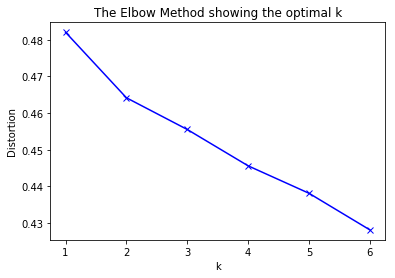

In [23]:
X = c_grouped.drop('Municipalities', 1)
distortions = []
K = range(1,7)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


From the above it seems that the optimal k is 3

In [24]:
k_o = 3

kmeans= KMeans(n_clusters=k_o, random_state=0).fit(X)

kl=kmeans.labels_
kl

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 0, 1, 0,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

Now let's create a new data frame that includes the cluster and the top 10 venues

In [25]:
c_venues_sorted.insert(0, 'Cluster Labels', kl)

c_merged = chennai_df
c_merged = c_merged.join(c_venues_sorted.set_index('Municipalities'), on ='Neighbourhood')

c_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Red Hills,13.19543,80.18431,1.0,Indian Restaurant,Shopping Mall,Movie Theater,Gym,Multiplex,Fish Market,Food Court,Food & Drink Shop,Food,Flower Shop
1,Royapuram,13.11394,80.29420,1.0,Indian Restaurant,Ice Cream Shop,Convenience Store,Dessert Shop,Spa,Movie Theater,Fish Market,Food Truck,Food Court,Food & Drink Shop
2,Korukkupet,13.11680,80.27726,1.0,Vegetarian / Vegan Restaurant,Indie Movie Theater,Boutique,Department Store,Dessert Shop,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
3,Vyasarpadi,13.11778,80.25168,1.0,Pharmacy,Department Store,Bakery,Chinese Restaurant,Fish Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
4,Tondiarpet,13.12923,80.28955,1.0,Harbor / Marina,Historic Site,Pharmacy,Beach,Fried Chicken Joint,Diner,Flea Market,Cricket Ground,Food Truck,Food Court


In [26]:
c_merged.dropna(inplace=True)
c_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Red Hills,13.19543,80.18431,1.0,Indian Restaurant,Shopping Mall,Movie Theater,Gym,Multiplex,Fish Market,Food Court,Food & Drink Shop,Food,Flower Shop
1,Royapuram,13.11394,80.29420,1.0,Indian Restaurant,Ice Cream Shop,Convenience Store,Dessert Shop,Spa,Movie Theater,Fish Market,Food Truck,Food Court,Food & Drink Shop
2,Korukkupet,13.11680,80.27726,1.0,Vegetarian / Vegan Restaurant,Indie Movie Theater,Boutique,Department Store,Dessert Shop,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
3,Vyasarpadi,13.11778,80.25168,1.0,Pharmacy,Department Store,Bakery,Chinese Restaurant,Fish Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
4,Tondiarpet,13.12923,80.28955,1.0,Harbor / Marina,Historic Site,Pharmacy,Beach,Fried Chicken Joint,Diner,Flea Market,Cricket Ground,Food Truck,Food Court


### Create a map to visualize clusters 

In [27]:
address = 'Chennai, Tamil Nadu'
geolocater = Nominatim(user_agent = 'ny_explorer')
location = geolocater.geocode(address)
latitude = location.latitude
longitude = location.longitude 
print('The geograpical coordinates of Chennai are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Chennai are 13.0801721, 80.2838331.


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_o)
ys = [i + x + (i*x)**2 for i in range(k_o)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(c_merged['Latitude'], c_merged['Longitude'], c_merged['Neighbourhood'], c_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [29]:
c1=c_merged.loc[c_merged['Cluster Labels'] == 0, c_merged.columns[[0] + list(range(4, c_merged.shape[1]))]]
print(c1.shape)
print(c1['1st Most Common Venue'].value_counts())
c1

(35, 11)
Indian Restaurant      31
Indie Movie Theater     2
Pharmacy                1
Light Rail Station      1
Name: 1st Most Common Venue, dtype: int64


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Tiruvottiyur,Indie Movie Theater,Indian Restaurant,Beach,Historic Site,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food
12,Sowcarpet,Indian Restaurant,Restaurant,Market,Food Truck,Harbor / Marina,Video Store,Dessert Shop,Fish Market,Cricket Ground,Food Court
15,Central,Indian Restaurant,South Indian Restaurant,Movie Theater,Fish Market,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
20,Parry's Corner,Indian Restaurant,Market,Video Store,Museum,Fish Market,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food
21,Purasawalkam,Indian Restaurant,Hotel,Italian Restaurant,Pizza Place,South Indian Restaurant,Hostel,Juice Bar,Historic Site,Fast Food Restaurant,Farmers Market
25,New Washermenpet,Pharmacy,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
30,Periamet,Indian Restaurant,Bookstore,Pizza Place,Hotel,Vegetarian / Vegan Restaurant,Soccer Stadium,Nightclub,Farmers Market,Movie Theater,Fish Market
31,Choolai,Indian Restaurant,Ice Cream Shop,Soccer Stadium,Hotel,Clothing Store,Women's Store,Fast Food Restaurant,Food Truck,Food Court,Food & Drink Shop
37,Manjambakkam,Indian Restaurant,Lake,Women's Store,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
40,T.V.K. Nagar,Indie Movie Theater,Indian Restaurant,Historic Site,Coworking Space,Cricket Ground,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


Cluster 2

In [33]:
c2=c_merged.loc[c_merged['Cluster Labels'] == 1, c_merged.columns[[0] + list(range(4, c_merged.shape[1]))]]
print(c2.shape)
print(c2['1st Most Common Venue'].value_counts())
c2

(109, 11)
Indian Restaurant                26
Pizza Place                       7
Fast Food Restaurant              6
Pharmacy                          4
Bakery                            4
Asian Restaurant                  3
Department Store                  3
Clothing Store                    3
Hotel                             3
Food Court                        3
Juice Bar                         2
Convenience Store                 2
Restaurant                        2
Bookstore                         2
Snack Place                       2
Vegetarian / Vegan Restaurant     2
Café                              2
Tea Room                          2
Light Rail Station                2
Market                            2
Beach                             2
Indie Movie Theater               2
Park                              2
Art Gallery                       1
Surf Spot                         1
Bike Rental / Bike Share          1
Harbor / Marina                   1
Thai Restaurant   

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Red Hills,Indian Restaurant,Shopping Mall,Movie Theater,Gym,Multiplex,Fish Market,Food Court,Food & Drink Shop,Food,Flower Shop
1,Royapuram,Indian Restaurant,Ice Cream Shop,Convenience Store,Dessert Shop,Spa,Movie Theater,Fish Market,Food Truck,Food Court,Food & Drink Shop
2,Korukkupet,Vegetarian / Vegan Restaurant,Indie Movie Theater,Boutique,Department Store,Dessert Shop,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
3,Vyasarpadi,Pharmacy,Department Store,Bakery,Chinese Restaurant,Fish Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop
4,Tondiarpet,Harbor / Marina,Historic Site,Pharmacy,Beach,Fried Chicken Joint,Diner,Flea Market,Cricket Ground,Food Truck,Food Court
7,Minjur,Park,Women's Store,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
8,Old Washermenpet,Women's Store,Department Store,Fish Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
9,Madhavaram,Park,Ice Cream Shop,Women's Store,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
10,Manali New Town,Bike Rental / Bike Share,Women's Store,Fish Market,Fruit & Vegetable Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
11,Naravarikuppam,Hotel,Gym,Women's Store,Fast Food Restaurant,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


Cluster 3

In [32]:
c3=c_merged.loc[c_merged['Cluster Labels'] == 2, c_merged.columns[[0] + list(range(4, c_merged.shape[1]))]]
print(c3.shape)
print(c3['1st Most Common Venue'].value_counts())
c3

(3, 11)
Pharmacy    3
Name: 1st Most Common Venue, dtype: int64


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Mathur MMDA,Pharmacy,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
80,Thirunindravur,Pharmacy,Furniture / Home Store,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market
90,Mangadu,Pharmacy,Fruit & Vegetable Store,Coworking Space,Cricket Ground,Fried Chicken Joint,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


## Results and Discussion <a name="results"></a>

Based on the above results, the most popular restaurant in Chennai is the Indian restaurant, being the most common venue restaurant for 21 neighborhoods and showing as the 2nd most common venue for other neighborhoods in cluster 1. It should also be noted that restaurants in general are in the top 10 for all districts in cluster 2 as well. Based on these results the recommended type of restaurant to open is an Indian restaurant, based one where they are most common, we feel they would have most success in any district in cluster 1, where it is not shown as 1st most common venue. If stakeholders wish to avoid competition, they can choose a district in cluster 2 where Indian restaurants do not show up in the top 10, such as Minjur or Old Washermenpet, as it can be assumed, they will have success there due the similarities they share with other clusters. We do not recommend opening an Indian restaurant in cluster 3, as there are no restaurants appearing in the top 10. The decision however is ultimately left to the stakeholder’s discretion. 

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find the best type of restaurant to open in Chennai, Tamil Nadu and a suitable location for it. Based on the analysis we conducted we recommend opening an Indian restaurant in any one of the neighborhoods located in cluster 1, based on how common it is in this area. We leave the decision of which district specifically up to stakeholders. It should be noted however, that this report should not be the sole criterion for making this decision. Analyses such as these are only a tool to aid the decision-making process and are only as good as the data and methods (which are never perfect) used in them. We recommend using other methods, tools and forms of decision-making criteria before reaching a final decision. 